Keras training model for image classification that starts with 224x224x3 images and interleaves convolution, batchnorm, relu, and pooling, repeatedly, in this order.
Adopted from https://keras.io/examples/vision/image_classification_from_scratch/

Download the dataset

In [1]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -q kagglecatsanddogs_5340.zip
!ls PetImages

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   104M      0  0:00:07  0:00:07 --:--:--  104M
Cat  Dog


Remove malformed images, that are not properly encoded as JPEGs.

In [2]:
import os
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


Split the images into training and validation set

In [3]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

image_size = (180, 180)
batch_size = 128

train_ds, val_ds = image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

2024-02-24 20:02:36.507158: E external/local_xla/xla/stream_executor/plugin_registry.cc:91] Invalid plugin kind specified: DNN
2024-02-24 20:02:36.569668: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-24 20:02:37.090994: E external/local_xla/xla/stream_executor/plugin_registry.cc:91] Invalid plugin kind specified: DNN
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/usr/local/lib/python3.9/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


2024-02-24 20:02:39.635573: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 32222 MB memory:  -> device: 0, name: , pci bus id: 0000:3f:00.0
2024-02-24 20:02:39.877593: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 32222 MB memory:  -> device: 1, name: , pci bus id: 0000:43:00.0


Visualize dataset

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
2024-02-24 20:02:42.490055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


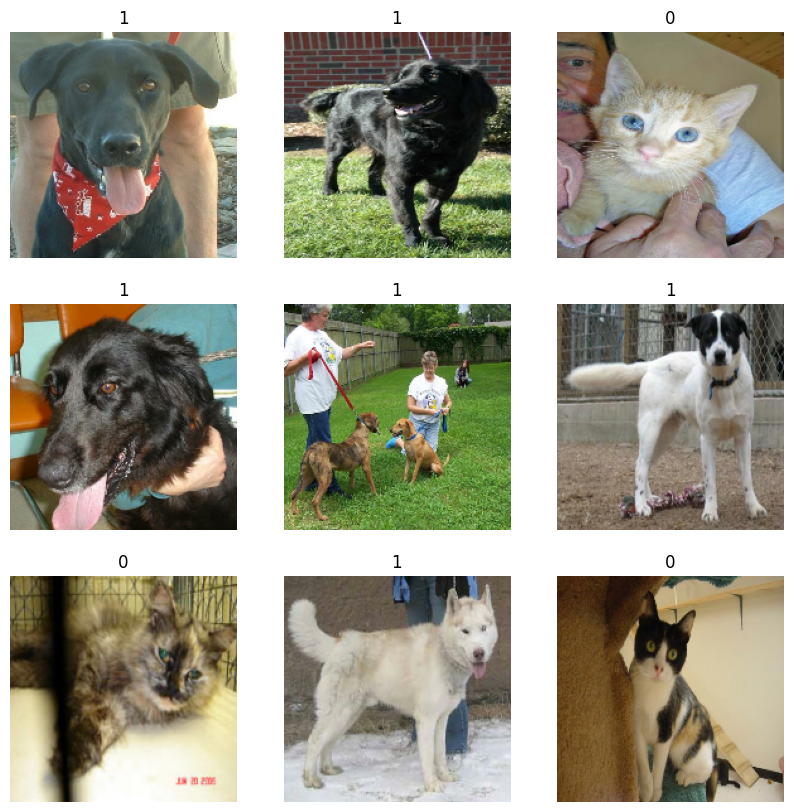

In [4]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Do the data augmentation for training. We resize the image to (224, 224, 3) so that the input for the training model satisfies the requirement.

In [5]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, Resizing

data_augmentation_layers = [
    Resizing(224, 224),
    RandomFlip("horizontal"),
    RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

Visualize after data augmentation

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
2024-02-24 20:02:45.828272: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


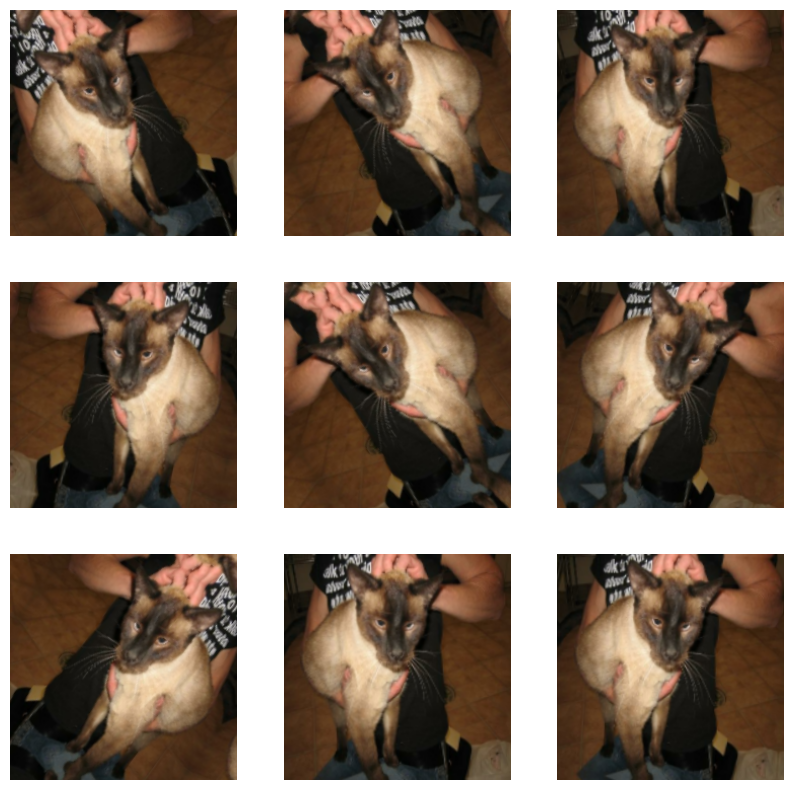

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

Build a basic model with Conv2D, Batchnorm, relu and maxpooling in that order and display the model as a dot graph.

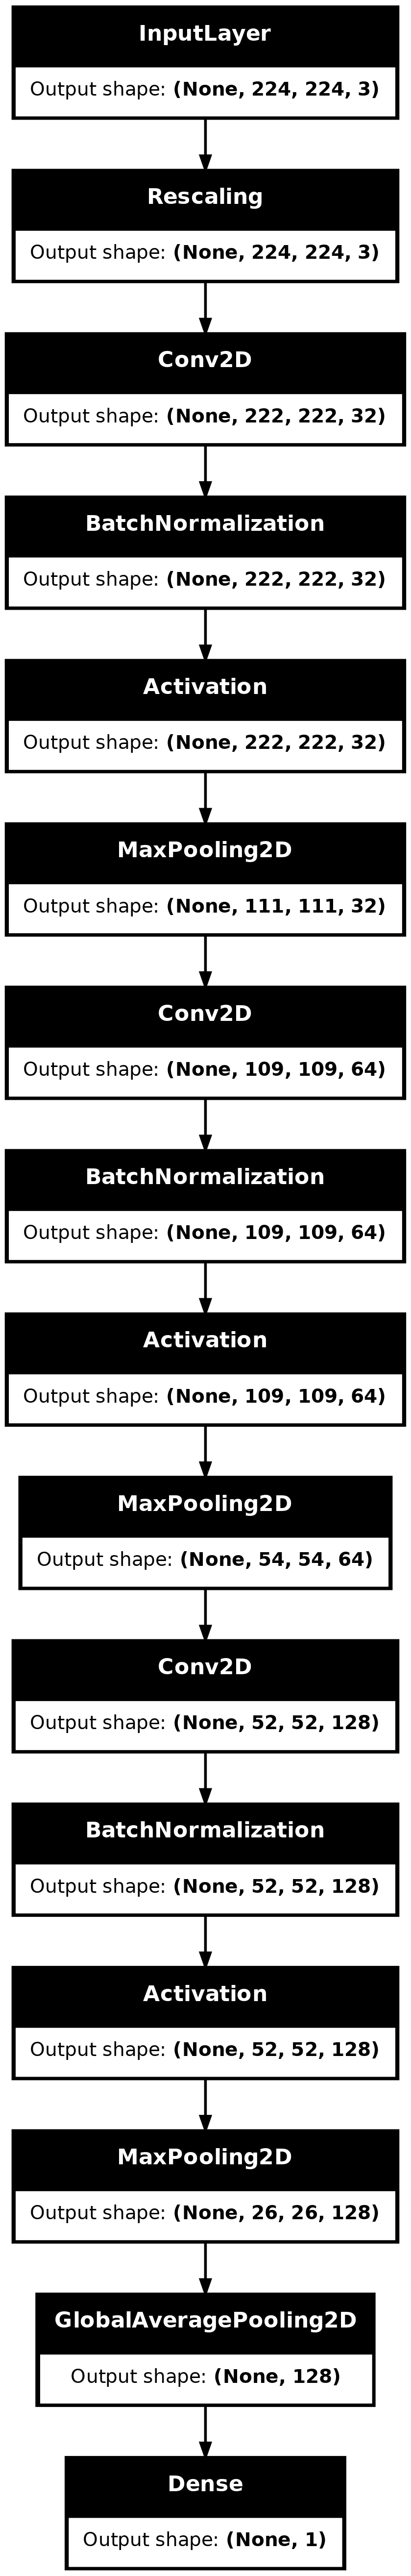

In [7]:
from tensorflow.keras import Input
from tensorflow.keras.layers import Rescaling, Conv2D, BatchNormalization, MaxPooling2D, Activation, Dense, GlobalAveragePooling2D

def make_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Entry block
    x = Rescaling(1.0 / 255)(inputs)
    for size in (32, 64, 128):
        x = Conv2D(size, 3)(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = MaxPooling2D()(x)

    x = GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    # We specify activation=None so as to return logits
    outputs = Dense(units, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)


model = make_model(input_shape=(224,224) + (3,), num_classes=2)
tf.keras.utils.plot_model(model, show_shapes=True)

Setup data pipeline for training.

In [8]:
from tensorflow import data as tf_data
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)

val_ds = val_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)


Train for 25 epochs.

In [9]:
epochs = 25

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/2


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
I0000 00:00:1708804970.483868  972684 service.cc:145] XLA service 0x7f532c004230 initialized for platform ROCM (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1708804970.483917  972684 service.cc:153]   StreamExecutor device (0): , AMDGPU ISA version: gfx906:sramecc+:xnack-
I0000 00:00:1708804970.483921  972684 service.cc:153]   StreamExecutor device (1): , AMDGPU ISA version: gfx906:sramecc+:xnack-
2024-02-24 20:02:50.678273: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1708804973.288227  972684 device_compiler.h:187] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 15/147 ━━━━━━━━━━━━━━━━━━━━ 15s 114ms/step - acc: 0.5105 - loss: 0.8028

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 22/147 ━━━━━━━━━━━━━━━━━━━━ 14s 114ms/step - acc: 0.5087 - loss: 0.8046

 42/147 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - acc: 0.5054 - loss: 0.8079

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 45/147 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - acc: 0.5046 - loss: 0.8086

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 48/147 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - acc: 0.5039 - loss: 0.8093

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 50/147 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - acc: 0.5035 - loss: 0.8097

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - acc: 0.4989 - loss: 0.8144

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 30s 153ms/step - acc: 0.4989 - loss: 0.8144 - val_acc: 0.5042 - val_loss: 0.8090
Epoch 2/2


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 24/147 ━━━━━━━━━━━━━━━━━━━━ 14s 122ms/step - acc: 0.4983 - loss: 0.8149

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 30/147 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - acc: 0.4983 - loss: 0.8149

 40/147 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - acc: 0.4978 - loss: 0.8154

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 42/147 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - acc: 0.4977 - loss: 0.8155

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 45/147 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - acc: 0.4976 - loss: 0.8157

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - acc: 0.4969 - loss: 0.8164

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step - acc: 0.4969 - loss: 0.8164 - val_acc: 0.5042 - val_loss: 0.8090
